In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno
import os
import numpy as np
import pickle as pk

# Puede utilizar esta extension si trabaja en colaboratory:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/ejercicio')

In [ ]:
# cargar con internet
# raw_data_path = 'https://raw.githubusercontent.com/NicoCaro/DataScienceLab/master/ejercicios/ejercicio%203/data/news.csv'
# raw_df = pd.read_csv(raw_data_path, index_col=0)

# P1. Carga y Exploracion

## 1.Crear columna delta_time 

In [56]:
# directorio PRSA_Data 
list_dir = os.listdir('PRSA_Data')
# cargar todos los csv como un mismo dataframe
data = pd.concat([pd.read_csv('PRSA_Data/'+list_dir[i], index_col=0) for i in range(len(list_dir))],
                 ignore_index=True, sort=False)

In [57]:
# Agregar columna 'delta_time' al dataframe data, esta columna tiene
# la diferencia de tiempo con la fecha inicial '2013, 3, 1, 0', 
# con dtype: timedelta64[ns]
data['delta_time'] = list(pd.to_datetime(data[data.columns[:4]])-pd.Timestamp(2013, 3, 1, 0))

## 2. Analizar  correlaciones de presencia de valores faltantes en las diferentes estaciones. Generar visualizaciones y discutir

In [58]:
# columnas que representan los contaminantes
var_cont = ['PM2.5', 'PM10', 'SO2', 'NO2','CO', 'O3']

# ver porcentaje valores faltantes en estas columnas 
(data[var_cont].isnull().sum() / data.shape[0])*100
# Es en general a lo mas un 4.9% de datos perdidos

PM2.5    2.076916
PM10     1.532674
SO2      2.143937
NO2      2.879497
CO       4.919813
O3       3.155421
dtype: float64

In [59]:
# ademas vemos los tipos de datos para ver si existen strings 
# o datos faltantes en otro formato
data[var_cont].info()
# como todos son del tipo float64, por lo que podemos seguir sin 
# hacer replace

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PM2.5   412029 non-null  float64
 1   PM10    414319 non-null  float64
 2   SO2     411747 non-null  float64
 3   NO2     408652 non-null  float64
 4   CO      400067 non-null  float64
 5   O3      407491 non-null  float64
dtypes: float64(6)
memory usage: 19.3 MB


C:\Users\gabri\anaconda3\lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  "Plotting a sparkline on an existing axis is not currently supported. "


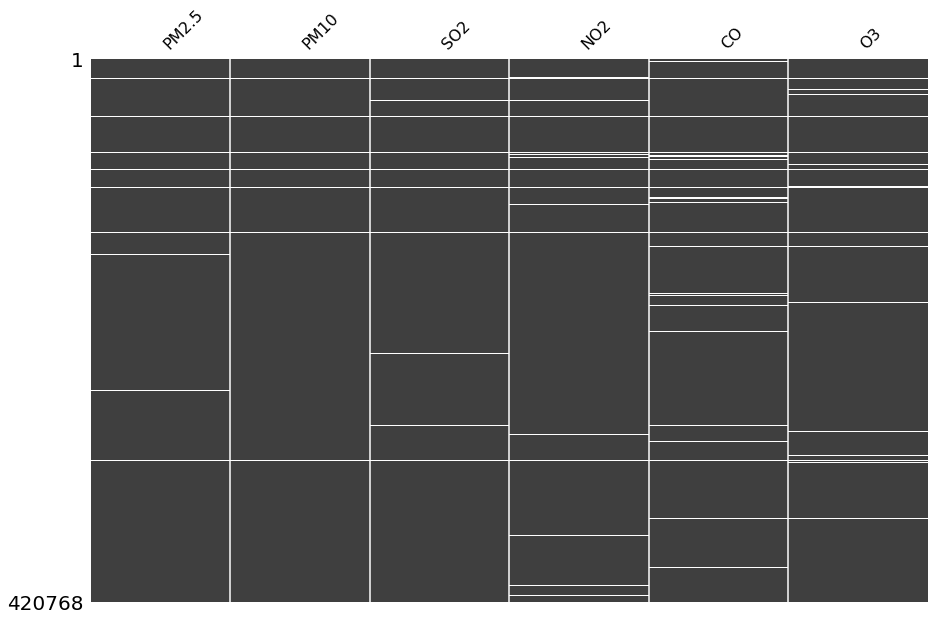

In [60]:
fig, ax = plt.subplots(figsize = [15, 10])
msno.matrix(data[var_cont],ax = ax, sparkline=True)

### En la anterior visualización se puede notar que los valores faltantes
### se observa que los valores faltantes para PM10 tambien lo son para 
### el resto de los contaminantes, calculamos el porcentaje de filas para 
### las que esta observacion es cierta

In [61]:
# ver porcentaje valores faltantes las filas de valores faltantes
# de la columna PM10
(data[var_cont][data['PM10'].isnull()].isnull().sum() / 
 data[var_cont][data['PM10'].isnull()].shape[0])*100

PM2.5     96.650644
PM10     100.000000
SO2       80.942782
NO2       81.625058
CO        82.322841
O3        77.903551
dtype: float64

### Como el porcentaje es mayor a 80% en 4 de la 5 columnas
### se decide eliminar todas las filas con datos faltantes 
### asociados a PM10

In [62]:
data = data[data['PM10'].isnull() == False].reset_index(drop=True)

### Ahora visualizamos los datos faltantes nuevamente

C:\Users\gabri\anaconda3\lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  "Plotting a sparkline on an existing axis is not currently supported. "


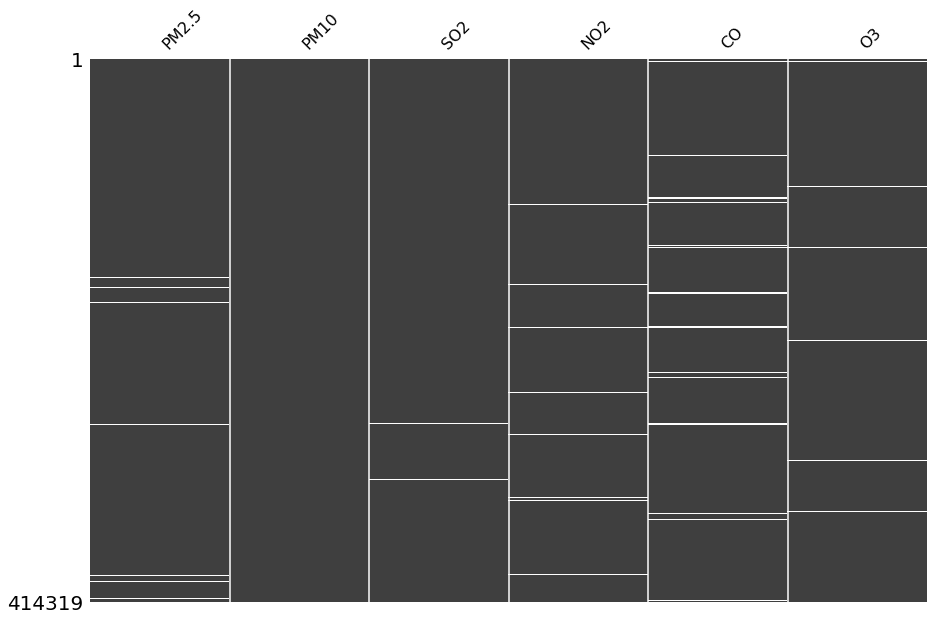

In [65]:
fig, ax = plt.subplots(figsize = [15, 10])
msno.matrix(data[var_cont],ax = ax, sparkline=True)

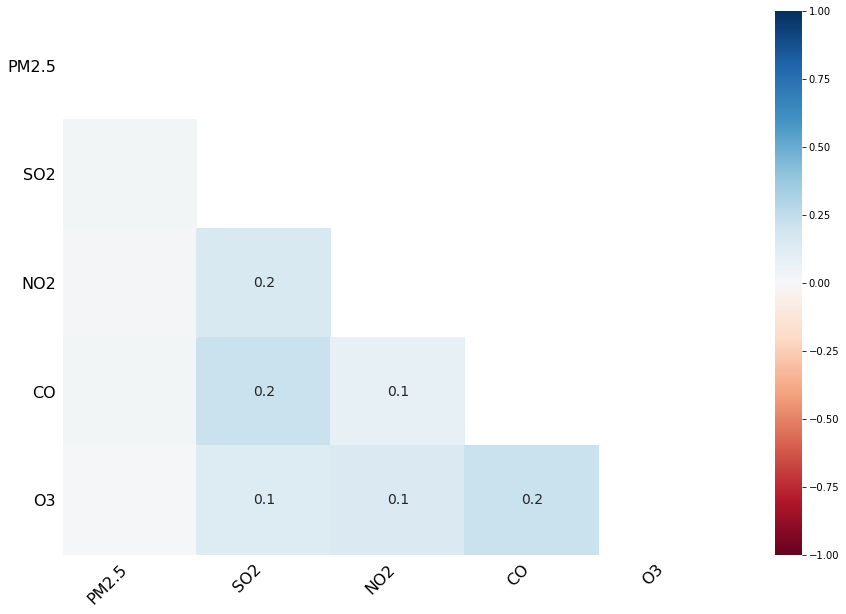

In [66]:
fig, ax = plt.subplots(figsize = [15, 10])
msno.heatmap(data[var_cont], ax = ax)

### Notamos en este caso que las correlaciones entre valores
### valores faltantes ahora son bajas

## 3. En las columnas de contaminantes, rellene los valores faltantes mediante interpolacion. Pruebe diferentes metodos de interpolacion, seleccione un y fundamente su eleccion.

In [80]:
data[var_cont] = data[var_cont].interpolate(method='quadratic')

### Esperar respuesta de que significa probar con distintos y 
### revisar si cuadratic hace una regression cuadratica

In [83]:
(data.isnull().sum() / data.shape[0])*100

year          0.000000
month         0.000000
day           0.000000
hour          0.000000
PM2.5         0.000000
PM10          0.000000
SO2           0.000000
NO2           0.000000
CO            0.000000
O3            0.000000
TEMP          0.095579
PRES          0.094372
DEWP          0.096785
RAIN          0.093648
wd            0.433965
WSPM          0.076028
station       0.000000
delta_time    0.000000
dtype: float64

### en las restantes columnas el porcentaje de valores restantes
### es bajo (<0.1), excepto en la columna wd, por lo que se considera
### eliminar el resto de valores faltantes si es necesario

## 4. Analice las correlaciones para cada contaminantes en las diferentes estaciones. Genere visualizaciones, discuta lo observado y seleccione el contaminante que tenga el menor promedio de correlacion entre estaciones. Para dicho contaminante, seleccione las tres estaciones que tengan el promedio de correlacion mas alto.

### Se genera un heatmap con las correlaciones de los contaminantes

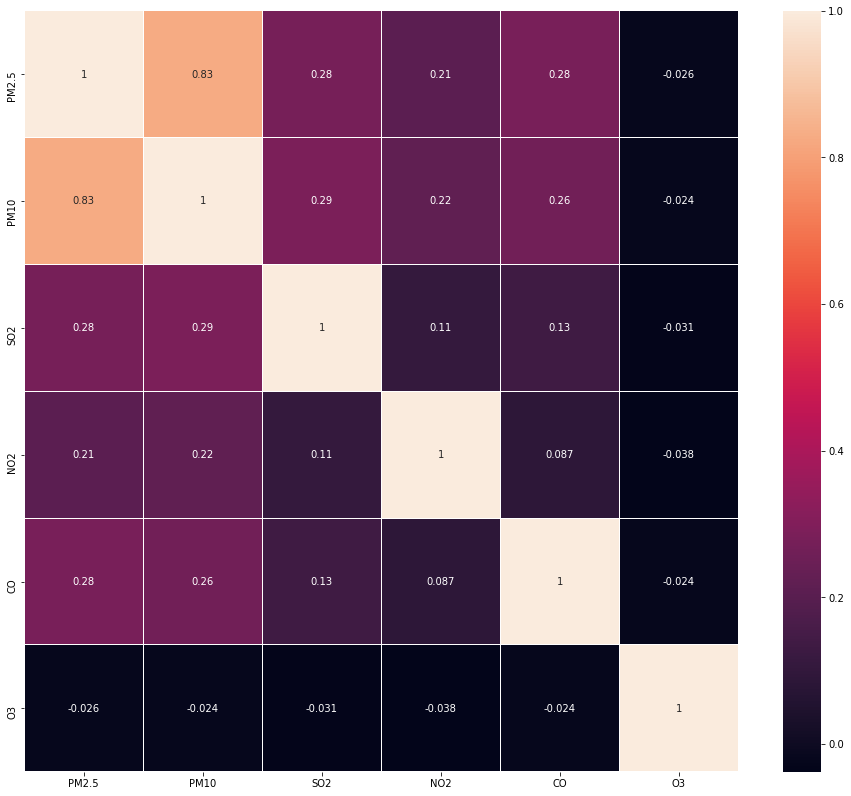

In [93]:
corrmat = data[var_cont].corr()
fig, ax = plt.subplots(figsize=[16, 14])
sns.heatmap(corrmat, vmin=np.min(np.min(corrmat)), vmax=1, linewidths=.01, annot=True)

### Podemos observar que hay fuerte correlacion entre PM10 y PM2.5 (0.83)
### Tambien notamos que las demas correlaciones son mas bien bajas (<0.3, >0.004). ahora se calcula el promedio de correlacion.

In [101]:
(corrmat.abs().sum()-1)/5

PM2.5    0.323599
PM10     0.323339
SO2      0.167070
NO2      0.131367
CO       0.157852
O3       0.028535
dtype: float64

### Se elige la columna O3 por tener el menor promedio, luego se calcula
### las 3 estaciones mas correlacionadas con O3

In [112]:
corrmat['O3'].nlargest(4)

O3       1.000000
PM10    -0.023606
CO      -0.024293
PM2.5   -0.025661
Name: O3, dtype: float64

### Los 3 mas correlacionados son PM10, CO y PM2.5

## 5. Descomponga en una tendencia, una señal periodica y su residuo; la señal del contaminante seleccionado en cada una de las 3 estaciones seleccionadas. Genere visualizaciones, discuta lo observado ademas de explicar el comportamiento de dicha funcion.